In [1]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# define the responses function, in this example, we use sum(only two dimension) function
def twoDsum(x):
    return sum(x)

#algorithm we use to update samples, and we here consider Modified Metropolis
###modified metropolis
def modmetro(nc,ns,d,z,q):
    for j in range(1,nc+1):
        for m in range(1,ns+1):
            ### step 1
            for k in range(1,d+1):
                a = z[j-1,k-1,m-1]+np.random.randn(1)
                r = min(1, norm.pdf(a)/norm.pdf(z[j-1,k-1,m-1]))
                if np.random.rand(1)<r:
                    q[k-1]=a
                else:
                    q[k-1]=z[j-1,k-1,m-1]
            ###step 2 q belongs to F_L or not
            if twoDsum(q)>Y[L-1]: ###responses
                z[j-1,:,m]=q
            else:
                z[j-1,:,m]=z[j-1,:,m-1]
    return z


In [2]:
d = 2 #1000 #dimension of the input space 
YF = 9 #200 #critical threshold (gx>=YF)
pF = 1 - norm.cdf(YF/np.sqrt(d)) #true value of the failure proability
n = 1000 #3000 #number of samples per level
p = 0.1 #level probability
nc = int(n*p) #number of Markov chains
ns = int((1-p)/p) #number of states in each chain

In [3]:
L = 0 # zero level
Lmax = 100 # define the possible maximum of number of levels
X = np.zeros((n,d,Lmax)) #samples for different levels
x = np.random.randn(n,d) # Monte Carlo samples(initial samples)
X[:,:,0] = x ### samples for zero level
nF = np.zeros(Lmax) # number of failure samples
y = np.zeros((Lmax,n)) # responses
z = np.zeros((nc,d,ns+1)) # seeds
Y = np.zeros(Lmax)
q = np.zeros(d)## potential next state in Markov chain?


In [4]:
for i in range(1, n+1):
    y[0,i-1] = twoDsum(x[i-1,:]) #zero level response
    if y[0,i-1]>YF: # whether it falls in failure domain
        nF[0]=nF[0]+1

In [5]:
while (nF[L]/n)<p: # stopping criterion
    L=L+1 # next conditional level is needed
    w = -y[L-1,:]
    ind = sorted(range(len(w)), key=lambda k: w[k])# original index of descending responses
    y[L-1,:] = y[L-1,ind] #renumbered responses
    X[:,:, L-1] = X[ind,:,L-1] # renumbered samples
    Y[L-1] = (y[L-1,nc-1]+y[L-1,nc])/2 #L^th intermediate threshold
    z[:,:,0] = X[range(0,nc),:, L-1] # seeds of Markov chain
    z = modmetro(nc,ns,d,z,q)###modified metropolis algorithm
    for j in range(1,nc+1):
        for m in range(1,ns+2):
            X[(j-1)*(ns+1)+m-1,:,L]=z[j-1,:,m-1]### update L-th level samples
    z = np.zeros((nc,d,ns+1))
    for i in range(1,n+1):
        y[L, i-1] = twoDsum(X[i-1,:,L]) ##responses
        if y[L,i-1]>YF:
            nF[L]=nF[L]+1


In [6]:
pF_SS = (p**(L))*(nF[L])/n ###final subset simulation estimation
N=n+n*(1-p)*(L) 

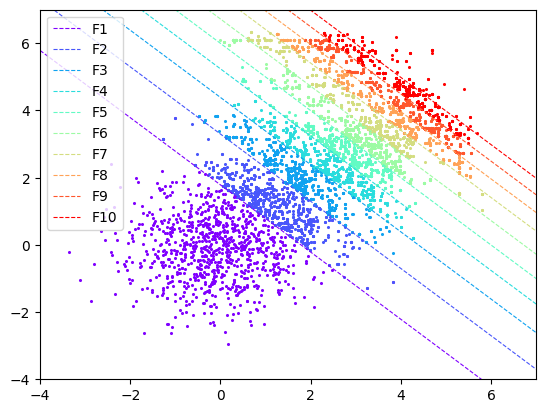

In [44]:
####plot 
colors = cm.rainbow(np.linspace(0, 1, int(L)))
xaxis = [-4,7]

for i, c in zip(range(1,L+1),colors):
    plt.scatter(X[:,0,i-1],X[:,1,i-1],color = c, s=1.5)
    yaxis = Y[i-1]-xaxis
    plt.plot(xaxis, yaxis, linestyle='dashed', color = c, linewidth = 0.8, label = 'F'+str(i))
plt.xlim([-4, 7])
plt.ylim([-4, 7])
plt.legend()
plt.show()